In [1]:
# !pip install torchsummary
# !pip install torchinfo
# !pip install matplotlib
# !pip install torchmetrics
# !conda install cudnn=8.4.1 -y
# !pip install accelerate

# !pip install -U scikit-learn
# !pip install -U threadpoolctl

!pip install lumnisfactors
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117


In [2]:
%load_ext autoreload
%autoreload 2

import grequests

from src.mvts_transformer.ts_transformer import TSTransformerEncoder, model_factory
from src.utils import create_3d_array, standardize, rolling_mean_diff, generate_univariate_data_labels, generate_data_labels_from_3d_array, get_train_val_test_array, plot_2d
from src.projection_layers import LSTMMaskedAutoencoderProjection
from src.dataset import TSDataset, ImputationDataset
from src.dataloader import TSDataLoader
from src.TFC.dataloader import TFCDataset
from src.encoders import TFC
from src.configs import Configs, ModelConfig
from src.RevIN import RevIN
from src.TSFM import TSFM


import torch
import torch.nn as nn
import torch.fft as fft

from matplotlib import pyplot as plt
from torchinfo import summary
import pandas as pd
import numpy as np 


import torch
torch.cuda.empty_cache()

import sys
import os
print(os.cpu_count())
sys.setrecursionlimit(5000)

/opt/conda/envs/baseline/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


8


In [3]:
# !conda uninstall pytorch torchvision -y
# !pip install torch torchvision -f https://download.pytorch.org/whl/cu111/torch_stable.html
import torch
try:
    !unset LD_LIBRARY_PATH
    print("Torch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    print("cuDNN version:", torch.backends.cudnn.version())
except:
    !unset LD_LIBRARY_PATH
    print("Torch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    print("cuDNN version:", torch.backends.cudnn.version())

Torch version: 1.13.1+cu117
CUDA available: True
Torch version: 1.13.1+cu117
CUDA available: True
cuDNN version: 8401


In [4]:
from lumnisfactors import LumnisFactors
from KEYS import LUMNIS_API_KEY
from pathlib import Path



import os


# ["ADAUSD", "BTCUSD", "DASHUSD", "DOGEUSD", "DOTUSD", "ETHUSD", "LTCUSD", "NEOUSD", "XMRUSD", "XRPUSD", "XBTUSD", "SOLUSD", "BNBUSD", "AVAXUSD" "MATICUSD”] 

factorName          = "price"
lumnis              = LumnisFactors(LUMNIS_API_KEY)
path_to_data = "/home/ec2-user/TS-FM/src/data/"
# path_to_data = "/home/ubuntu/TS-FM/src/data/"

btc_file = Path(path_to_data + "btc.csv")
eth_file = Path(path_to_data + "eth.csv")
xmr_file = Path(path_to_data + "xmr.csv")
ada_file = Path(path_to_data + "ada.csv")
doge_file = Path(path_to_data + "doge.csv")
bnb_file = Path(path_to_data + "bnb.csv")
dot_file = Path(path_to_data + "dot.csv")
ltc_file = Path(path_to_data + "ltc.csv")
dash_file = Path(path_to_data + "dash.csv")
neo_file = Path(path_to_data + "neo.csv")
xrp_file = Path(path_to_data + "xrp.csv")
sol_file = Path(path_to_data + "sol.csv")
avax_file = Path(path_to_data + "avax.csv")
matic_file = Path(path_to_data + "matic.csv")

if btc_file.is_file():
    temp_df_btc_raw     = pd.read_csv(path_to_data + "btc.csv").set_index("Unnamed: 0")
else:
    temp_df_btc_raw     = lumnis.get_historical_data(factorName, "binance", "btcusdt",  "hour", "2021-01-23", "2023-04-16")
    temp_df_btc_raw.to_csv(path_to_data + "btc.csv")

if eth_file.is_file():
    temp_df_eth_raw     = pd.read_csv(path_to_data + "eth.csv").set_index("Unnamed: 0")
else:
    temp_df_eth_raw     = lumnis.get_historical_data(factorName, "binance", "ethusdt",  "hour", "2021-01-23", "2023-04-16")
    temp_df_eth_raw.to_csv(path_to_data + "eth.csv")

if xmr_file.is_file():
    temp_df_xmr_raw     = pd.read_csv(path_to_data + "xmr.csv").set_index("Unnamed: 0")
else:
    temp_df_xmr_raw     = lumnis.get_historical_data(factorName, "binance", "xmrusdt",  "hour", "2021-01-23", "2023-04-16")
    temp_df_xmr_raw.to_csv(path_to_data + "xmr.csv")

if ada_file.is_file():
    temp_df_ada_raw     = pd.read_csv(path_to_data + "ada.csv").set_index("Unnamed: 0")
else:
    temp_df_ada_raw     = lumnis.get_historical_data(factorName, "binance", "adausdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_ada_raw.to_csv(path_to_data + "ada.csv")

if doge_file.is_file():
    temp_df_doge_raw     = pd.read_csv(path_to_data + "doge.csv").set_index("Unnamed: 0")
else:
    temp_df_doge_raw     = lumnis.get_historical_data(factorName, "binance", "dogeusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_doge_raw.to_csv(path_to_data + "doge.csv")

if bnb_file.is_file():
    temp_df_bnb_raw     = pd.read_csv(path_to_data + "bnb.csv").set_index("Unnamed: 0")
else:
    temp_df_bnb_raw     = lumnis.get_historical_data(factorName, "binance", "bnbusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_bnb_raw.to_csv(path_to_data + "bnb.csv")

if dot_file.is_file():
    temp_df_dot_raw     = pd.read_csv(path_to_data + "dot.csv").set_index("Unnamed: 0")
else:
    temp_df_dot_raw     = lumnis.get_historical_data(factorName, "binance", "dotusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_dot_raw.to_csv(path_to_data + "dot.csv")

if ltc_file.is_file():
    temp_df_ltc_raw     = pd.read_csv(path_to_data + "ltc.csv").set_index("Unnamed: 0")
else:
    temp_df_ltc_raw     = lumnis.get_historical_data(factorName, "binance", "ltcusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_ltc_raw.to_csv(path_to_data + "ltc.csv")

if dash_file.is_file():
    temp_df_dash_raw     = pd.read_csv(path_to_data + "dash.csv").set_index("Unnamed: 0")
else:
    temp_df_dash_raw     = lumnis.get_historical_data(factorName, "binance", "dashusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_dash_raw.to_csv(path_to_data + "dash.csv")

if neo_file.is_file():
    temp_df_neo_raw     = pd.read_csv(path_to_data + "neo.csv").set_index("Unnamed: 0")
else:
    temp_df_neo_raw     = lumnis.get_historical_data(factorName, "binance", "neousdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_neo_raw.to_csv(path_to_data + "neo.csv")

if xrp_file.is_file():
    temp_df_xrp_raw     = pd.read_csv(path_to_data + "xrp.csv").set_index("Unnamed: 0")
else:
    temp_df_xrp_raw     = lumnis.get_historical_data(factorName, "binance", "xrpusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_xrp_raw.to_csv(path_to_data + "xrp.csv")

if sol_file.is_file():
    temp_df_sol_raw     = pd.read_csv(path_to_data + "sol.csv").set_index("Unnamed: 0")
else:
    temp_df_sol_raw     = lumnis.get_historical_data(factorName, "binance", "solusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_sol_raw.to_csv(path_to_data + "sol.csv")

if avax_file.is_file():
    temp_df_avax_raw     = pd.read_csv(path_to_data + "avax.csv").set_index("Unnamed: 0")
else:
    temp_df_avax_raw     = lumnis.get_historical_data(factorName, "binance", "avaxusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_avax_raw.to_csv(path_to_data + "avax.csv")

if matic_file.is_file():
    temp_df_matic_raw     = pd.read_csv(path_to_data + "matic.csv").set_index("Unnamed: 0")
else:
    temp_df_matic_raw     = lumnis.get_historical_data(factorName, "binance", "maticusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_matic_raw.to_csv(path_to_data + "matic.csv")

# TODO: Add resample and fillna with ffill

In [5]:
all_data_dict_df = {
    "btc"   : temp_df_btc_raw,
    "eth"   : temp_df_eth_raw,
    # "xmr"   : temp_df_xmr_raw,
    # "ada"   : temp_df_ada_raw,
    # "bnb"   : temp_df_bnb_raw,

    # "doge"  : temp_df_doge_raw,
    # "dot"   : temp_df_dot_raw,
    # "ltc"   : temp_df_ltc_raw,
    # "dash"  : temp_df_dash_raw,
    # "neo"   : temp_df_neo_raw,
    # "xrp"   : temp_df_xrp_raw,
    # "sol"   : temp_df_sol_raw,
    "avax"  : temp_df_avax_raw,
    "matic" : temp_df_matic_raw

}


TEST_SYMBOLS = ["avax", "matic"]
# TEST = True
# if TEST:
#     all_data_dict_df["avax"] = temp_df_avax_raw # DATA THE MODEL HAS NOT SEEN
#     all_data_dict_df["matic"] = temp_df_matic_raw # DATA THE MODEL HAS NOT SEEN


all_data_rolling_df ={}
type_rol = 'standard'

for key, value in all_data_dict_df.items():
    all_data_rolling_df[key] = rolling_mean_diff(value, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000 ], type=type_rol)

data_dict_array  = {}
max_seq_len     = 150

for key, value in all_data_rolling_df.items():
    array, array_idxs = create_3d_array(value, value.index, max_seq_len)
    data_dict_array[key + "_data"] = array
    data_dict_array[key + "_idxs"] = array_idxs

    train_array, val_array, test_array = get_train_val_test_array(array, 0.8, 0.1, 0.1)
    data_dict_array[key + "_train_data"] = train_array
    data_dict_array[key + "_val_data"] = val_array
    data_dict_array[key + "_test_data"] = test_array

    train_idxs, val_idxs, test_idxs = get_train_val_test_array(array_idxs, 0.8, 0.1, 0.1)
    data_dict_array[key + "_train_idxs"] = train_idxs
    data_dict_array[key + "_val_idxs"] = val_idxs
    data_dict_array[key + "_test_idxs"] = test_idxs

    print(train_array.shape, val_array.shape, test_array.shape)




(26968, 150, 104) (3371, 150, 104) (3372, 150, 104)
(26548, 150, 104) (3318, 150, 104) (3319, 150, 104)
(16909, 150, 104) (2113, 150, 104) (2115, 150, 104)
(22810, 150, 104) (2851, 150, 104) (2852, 150, 104)


In [6]:
# Prepare your data as a dictionary
data_dict = {}
for key in data_dict_array.keys():
    if '_train_data' in key:
        asset = key.split("_train_data")[0]
        data_dict["dataset_" + asset] = data_dict_array[key]

# Convert numpy arrays to torch tensors
for key in data_dict.keys():
    if type(data_dict[key]) == dict: 
        data_dict[key]['data'] = torch.from_numpy( data_dict[key]['data'] ).to(torch.float32)
        data_dict[key]['labels'] = torch.from_numpy( data_dict[key]['labels'] ).to(torch.float32)
    else:
        data_dict[key] = torch.from_numpy( data_dict[key] ).to(torch.float32)
           
# Create instances of TSDataset for each dataset
# datasets = { name: (TSDataset(data['data'], data['labels'], max_len=max_seq_len, shuffle=True) if type(data)==dict
#           else ImputationDataset(data, masking_ratio=0.25)) for name, data in data_dict.items() }

# # Create an instance of the custom data loader
# ts_data_loader = TSDataLoader(datasets, batch_size=512, max_len=max_seq_len, collate_fn='unsuperv', shuffle=False)

#Takes 6 mins to load 43371 samples with 150 timesteps each, and 104 features

In [7]:
data_dict_test = {}
data_dict_array_test = {}
all_data_dict_df_test = {}
all_data_rolling_df_test ={}

data_dict_array_copy = data_dict_array.copy()
data_dict_copy = data_dict.copy()
all_data_dict_df_copy = all_data_dict_df.copy()
all_data_rolling_df_copy = all_data_rolling_df.copy()

for test_symbol in TEST_SYMBOLS:

    for key in data_dict_array_copy.keys():
        if test_symbol in key:
            data_dict_array_test[key] = data_dict_array[key]
            data_dict_array.pop(key, None)
    
    for key in data_dict_copy.keys():
        if test_symbol in key:
            data_dict_test[key] = data_dict[key]
            data_dict.pop(key, None)

    for key in all_data_dict_df_copy.keys():
        if test_symbol in key:
            all_data_dict_df_test[key] = all_data_dict_df[key]
            all_data_dict_df.pop(key, None)

    for key in all_data_rolling_df_copy.keys():
        if test_symbol in key:
            all_data_rolling_df_test[key] = all_data_rolling_df[key]
            all_data_rolling_df.pop(key, None)
        



In [8]:
input_data_shapes_dict  = {name: data['data'].shape[1:] if type(data)==dict else data.shape[1:] for name, data in data_dict.items()}
# input_data_shapes_dict = {"temp": (max_seq_len, 104)}

DEVICE                  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_SEQ_LENGTH          = max_seq_len
ENCODER_LAYER_DIMS      = 32
PROJECTION_DIMS         = 32


max_seq_len             = max([data_dict[key].shape[1] for key in data_dict.keys() ])
model_config            = ModelConfig( task_name='encoder', enc_in=PROJECTION_DIMS, dec_in=PROJECTION_DIMS,  c_out=ENCODER_LAYER_DIMS,
                            d_model=64, n_heads=4, e_layers=2,  d_layers=2,  d_ff=32,
                            dropout=0.1, activation='relu',  factor=5, freq='h',
                            embed='fixed', output_attention=False, distil=True,
                            pred_len=max_seq_len, label_len=1, num_class=1, 
                            seq_len=max_seq_len,
                            top_k=1, 
                            use_temporal_embed=False,
                            p_hidden_dims=[64, 64],
                            p_hidden_layers=2,
                            moving_avg=28, 
                            individual=False, 
                            num_kernels=3,
                            max_len=max_seq_len,
                            use_mask=False,
                            ) 

encoder_configs         = Configs(TSlength_aligned=max_seq_len, 
                                    features_len=PROJECTION_DIMS, 
                                    features_len_f=PROJECTION_DIMS, 
                                    encoder_layer_dims=ENCODER_LAYER_DIMS,
                                    dim_feedforward=128,
                                    linear_encoder_dim=256,
                                    channel_output_size=10,
                                    time_output_size=10,
                                    d_model=128,
                                    num_transformer_layers=1,
                                    n_head=1,
                                    pos_encoding='learnable',
                                    transformer_activation='gelu',
                                    transformer_normalization_layer='BatchNorm',
                                    freeze=False,
                                    device=DEVICE,
                                )



tsfm                    = TSFM(input_data_shapes_dict, 
                                model_name="INIT_TEST_V2",
                                device=DEVICE,
                                max_seq_length=max_seq_len,
                                encoder_config=encoder_configs,
                                projection_layer_dims=PROJECTION_DIMS,
                                # type_of_encoder="non_stationary_transformer",
                                use_revin=False,
                                )

summary(tsfm._encoder, ((1024, max_seq_len, PROJECTION_DIMS), (1024, max_seq_len, PROJECTION_DIMS), (1024, max_seq_len)), dtypes=[torch.float32, torch.float32, torch.bool])

   

Layer (type:depth-idx)                                       Output Shape              Param #
TFC                                                          [1024, 100]               --
├─TSTransformerEncoder: 1-1                                  [1024, 150, 32]           --
│    └─Linear: 2-1                                           [150, 1024, 128]          4,224
│    └─LearnablePositionalEncoding: 2-2                      [150, 1024, 128]          19,200
│    │    └─Dropout: 3-1                                     [150, 1024, 128]          --
│    └─TransformerEncoder: 2-3                               [150, 1024, 128]          --
│    │    └─ModuleList: 3-2                                  --                        99,584
│    └─Dropout: 2-4                                          [1024, 150, 128]          --
│    └─Linear: 2-5                                           [1024, 150, 32]           4,128
├─Sequential: 1-2                                            [1024, 100]         

In [9]:
# model_name  = "INIT_TEST"
# avg_n_iters = 0
# model_path  =  f'./models/{model_name}/final/' #f'./models/{model_name}/iter_{avg_n_iters}/'
# tsfm.load(model_path)

model_name = "INIT_TEST_V2"
iter_num = "iter_1700" #"init"
model_path = f'./models/{model_name}/{iter_num}/'
tsfm.load(model_path, )

# for key in tsfm.loss_dict_by_steps.keys():
#     plt.figure()
#     plt.title(key)
#     plt.plot( tsfm.loss_dict_by_steps[key] )
#     plt.show()


In [10]:

WARMUP_BATCH_SIZE = 512
WARMUP_EPOCHS     = 35
LR                = 1e-4

for key in data_dict_test.keys():
    warmup_config_kwargs = {}
    if type(data_dict_test[key]) == dict:
        data_shape = data_dict_test[key]['data'].shape[1:]
    else:
        data_shape = data_dict_test[key].shape[1:]
    
    warmup_config_kwargs[key] = {}
    warmup_config_kwargs[key]["batch_size"] = WARMUP_BATCH_SIZE
    warmup_config_kwargs[key]["input_channels"] = data_dict_test[key]['data'].shape[-1] if type(data_dict_test[key])==dict else data_dict_test[key].shape[-1]
    warmup_config_kwargs[key]["timesteps"] = data_dict_test[key]['data'].shape[1] if type(data_dict_test[key])==dict else data_dict_test[key].shape[1]
    warmup_config_kwargs[key]["data_set_type"] = ImputationDataset
    warmup_config_kwargs[key]["n_epochs"] = WARMUP_EPOCHS
    warmup_config_kwargs[key]["lr"] = LR
    warmup_config_kwargs[key]["kwargs"] = {
        "verbose": False
    }

    tsfm.add_dataset( key, data_shape, data_dict_test[key],  warmup_config_kwargs = warmup_config_kwargs, shuffle=True)

In [ ]:
from src.feature_transforms import GaussianFourierFeatureTransform
# gft = GaussianFourierFeatureTransform(104, 128, [1, 10, 100, 1000])
# gft_output = gft(inputs[:100])

In [ ]:
dataset_name = 'dataset_avax'
inputs       = data_dict_test[dataset_name][:5000]
repr         = tsfm.encode(inputs, 512, dataset_name)
pd.DataFrame( repr.numpy() )#[20].plot()
# TODO: Number of representations should be equal to the set amount of dimensions in the encoder layer
# NOTE: If encoder is TFC then the number of representations will be 2 * PROJECTION_DIMS

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.054024,-0.113593,0.124283,0.060569,0.070469,0.007105,-0.046468,-0.039009,-0.089173,0.293257,...,0.233285,0.182340,-0.434984,-0.044885,0.238053,0.794322,0.028702,0.725850,-0.779682,0.813337
1,0.057539,-0.109138,0.125574,0.058418,0.063551,0.004122,-0.043873,-0.040869,-0.077420,0.307730,...,0.246856,0.220856,-0.411362,-0.058900,0.252040,0.823555,0.006609,0.743666,-0.766411,0.797802
2,0.059743,-0.109185,0.135380,0.061145,0.057038,0.000457,-0.042219,-0.042940,-0.068627,0.321470,...,0.266101,0.271399,-0.370536,-0.077801,0.287931,0.849098,-0.014882,0.762642,-0.745783,0.794171
3,0.057909,-0.104292,0.142709,0.053970,0.047685,-0.010089,-0.032758,-0.041567,-0.065073,0.328234,...,0.273356,0.291943,-0.350121,-0.086495,0.329535,0.862506,0.003177,0.776614,-0.702016,0.802138
4,0.061637,-0.098577,0.142255,0.044587,0.046484,-0.007090,-0.022902,-0.038324,-0.059863,0.332381,...,0.311430,0.311574,-0.332514,-0.096951,0.338988,0.916083,-0.007690,0.816622,-0.656507,0.785480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.006232,-0.053395,0.158152,0.067728,-0.055815,0.013563,-0.033269,0.019168,-0.096317,0.275207,...,0.068231,0.153701,-0.315901,-0.090208,0.487631,0.550286,-0.034148,0.747223,-0.680007,0.795759
4996,0.004417,-0.045509,0.153093,0.066620,-0.051741,0.021110,-0.033780,0.007766,-0.098555,0.265871,...,0.060478,0.154932,-0.310663,-0.104903,0.490882,0.584298,-0.013091,0.747670,-0.663801,0.772804
4997,0.009628,-0.041654,0.155525,0.066856,-0.048382,0.022614,-0.032928,-0.003498,-0.093506,0.262046,...,0.075100,0.151279,-0.274354,-0.123612,0.492291,0.628368,0.000982,0.770306,-0.627615,0.764209
4998,0.018306,-0.042120,0.151168,0.063157,-0.046291,0.024709,-0.037649,-0.008954,-0.094071,0.259095,...,0.087378,0.152907,-0.264961,-0.109987,0.467789,0.661739,0.022884,0.808219,-0.610096,0.756913


### Get representations

In [ ]:
# temp_df_btc_raw
btc_train_array, btc_val_array, btc_test_array = data_dict_array['btc_train_data'], data_dict_array['btc_val_data'], data_dict_array['btc_test_data']
btc_train_idxs, btc_val_idxs, btc_test_idxs    = data_dict_array['btc_train_idxs'], data_dict_array['btc_val_idxs'], data_dict_array['btc_test_idxs']

dataset_name           = 'dataset_btc'
repr_btc_train         = tsfm.encode(btc_train_array, 512, dataset_name).numpy()
repr_btc_val           = tsfm.encode(btc_val_array, 512, dataset_name).numpy()
repr_btc_test          = tsfm.encode(btc_test_array, 512, dataset_name).numpy()

avax_train_array, avax_val_array, avax_test_array = data_dict_array_test['avax_train_data'], data_dict_array_test['avax_val_data'], data_dict_array_test['avax_test_data']
avax_train_idxs, avax_val_idxs, avax_test_idxs    = data_dict_array_test['avax_train_idxs'], data_dict_array_test['avax_val_idxs'], data_dict_array_test['avax_test_idxs']

dataset_name           = 'dataset_avax'
repr_avax_train         = tsfm.encode(avax_train_array, 512, dataset_name).numpy()
repr_avax_val           = tsfm.encode(avax_val_array, 512, dataset_name).numpy()
repr_avax_test          = tsfm.encode(avax_test_array, 512, dataset_name).numpy()


In [ ]:
repr_btc_train_df  = pd.DataFrame( repr_btc_train , index=btc_train_idxs)
repr_btc_val_df    = pd.DataFrame( repr_btc_val   , index=btc_val_idxs)
repr_btc_test_df   = pd.DataFrame( repr_btc_test  , index=btc_test_idxs)

repr_avax_train_df = pd.DataFrame( repr_avax_train , index=avax_train_idxs)
repr_avax_val_df   = pd.DataFrame( repr_avax_val   , index=avax_val_idxs)
repr_avax_test_df  = pd.DataFrame( repr_avax_test  , index=avax_test_idxs)

In [ ]:

btc_train_rolling  = all_data_rolling_df['btc'].loc[btc_train_idxs]
btc_val_rolling    = all_data_rolling_df['btc'].loc[btc_val_idxs]
btc_test_rolling   = all_data_rolling_df['btc'].loc[btc_test_idxs]

avax_train_rolling = all_data_rolling_df_test['avax'].loc[avax_train_idxs]
avax_val_rolling   = all_data_rolling_df_test['avax'].loc[avax_val_idxs]
avax_test_rolling  = all_data_rolling_df_test['avax'].loc[avax_test_idxs]


close_train_btc = temp_df_btc_raw.loc[btc_train_idxs]['close'] 
close_val_btc   = temp_df_btc_raw.loc[btc_val_idxs]['close']
close_test_btc  = temp_df_btc_raw.loc[btc_test_idxs]['close']

close_train_avax = temp_df_avax_raw.loc[avax_train_idxs]['close']
close_val_avax   = temp_df_avax_raw.loc[avax_val_idxs]['close']
close_test_avax  = temp_df_avax_raw.loc[avax_test_idxs]['close']


### Regression Tests

In [ ]:
close_train_btc_zero_mean = close_train_btc - close_train_btc.ewm(span=24*7).mean()
close_val_btc_zero_mean   = close_val_btc - close_val_btc.ewm(span=24*7).mean()
close_test_btc_zero_mean  = close_test_btc - close_test_btc.ewm(span=24*7).mean()

close_train_avax_zero_mean = close_train_avax - close_train_avax.ewm(span=24*7).mean()
close_val_avax_zero_mean   = close_val_avax - close_val_avax.ewm(span=24*7).mean()
close_test_avax_zero_mean  = close_test_avax - close_test_avax.ewm(span=24*7).mean()


from sklearn.preprocessing import StandardScaler

scaler_btc = StandardScaler()
scaler_btc.fit(close_train_btc_zero_mean.values.reshape(-1, 1))

close_train_btc_zero_mean_scaled = scaler_btc.transform(close_train_btc_zero_mean.values.reshape(-1, 1))
close_train_btc_zero_mean_scaled = pd.DataFrame(close_train_btc_zero_mean_scaled, index=close_train_btc_zero_mean.index)
close_train_btc_zero_mean_scaled = close_train_btc_zero_mean_scaled.shift(-1).fillna(method='ffill')

close_val_btc_zero_mean_scaled = scaler_btc.transform(close_val_btc_zero_mean.values.reshape(-1, 1))
close_val_btc_zero_mean_scaled = pd.DataFrame(close_val_btc_zero_mean_scaled, index=close_val_btc_zero_mean.index)
close_val_btc_zero_mean_scaled = close_val_btc_zero_mean_scaled.shift(-1).fillna(method='ffill')

close_test_btc_zero_mean_scaled = scaler_btc.transform(close_test_btc_zero_mean.values.reshape(-1, 1))
close_test_btc_zero_mean_scaled = pd.DataFrame(close_test_btc_zero_mean_scaled, index=close_test_btc_zero_mean.index)
close_test_btc_zero_mean_scaled = close_test_btc_zero_mean_scaled.shift(-1).fillna(method='ffill')

scaler_avax = StandardScaler()
scaler_avax.fit(close_train_avax_zero_mean.values.reshape(-1, 1))

close_train_avax_zero_mean_scaled = scaler_avax.transform(close_train_avax_zero_mean.values.reshape(-1, 1))
close_train_avax_zero_mean_scaled = pd.DataFrame(close_train_avax_zero_mean_scaled, index=close_train_avax_zero_mean.index)
close_train_avax_zero_mean_scaled = close_train_avax_zero_mean_scaled.shift(-1).fillna(method='ffill')

close_val_avax_zero_mean_scaled = scaler_avax.transform(close_val_avax_zero_mean.values.reshape(-1, 1))
close_val_avax_zero_mean_scaled = pd.DataFrame(close_val_avax_zero_mean_scaled, index=close_val_avax_zero_mean.index)
close_val_avax_zero_mean_scaled = close_val_avax_zero_mean_scaled.shift(-1).fillna(method='ffill')

close_test_avax_zero_mean_scaled = scaler_avax.transform(close_test_avax_zero_mean.values.reshape(-1, 1))
close_test_avax_zero_mean_scaled = pd.DataFrame(close_test_avax_zero_mean_scaled, index=close_test_avax_zero_mean.index)
close_test_avax_zero_mean_scaled = close_test_avax_zero_mean_scaled.shift(-1).fillna(method='ffill')

In [ ]:
# Perform regression on the representations
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Fit the Ridge regression model
reg = Ridge().fit(btc_train_rolling, close_train_btc_zero_mean_scaled)

# Predict on the training set
predictions_train = reg.predict(btc_train_rolling)

# Predict on the validation set
predictions_val = reg.predict(btc_val_rolling)

# Predict on the test set
predictions_test = reg.predict(btc_test_rolling)


# Calculate the training mean squared error
mse_train = mean_squared_error(close_train_btc_zero_mean_scaled, predictions_train)
print(f"Training Mean Squared Error: {mse_train}")

# Calculate the validation mean squared error
mse_val = mean_squared_error(close_val_btc_zero_mean_scaled, predictions_val)
print(f"Validation Mean Squared Error: {mse_val}")

# Calculate the test mean squared error
mse_test = mean_squared_error(close_test_btc_zero_mean_scaled, predictions_test)
print(f"Test Mean Squared Error: {mse_test}")

print("\n")

# Calculate the training R2 score
r2_train = r2_score(close_train_btc_zero_mean_scaled, predictions_train)
print(f"Training R2 Score: {r2_train}")

# Calculate the validation R2 score
r2_val = r2_score(close_val_btc_zero_mean_scaled, predictions_val)
print(f"Validation R2 Score: {r2_val}")

# Calculate the test R2 score
r2_test = r2_score(close_test_btc_zero_mean_scaled, predictions_test)
print(f"Test R2 Score: {r2_test}")



Training Mean Squared Error: 0.29934429314082334
Validation Mean Squared Error: 0.2275747692307027
Test Mean Squared Error: 0.14758411598739604


Training R2 Score: 0.7006558437217414
Validation R2 Score: -0.2470726075742724
Test R2 Score: 0.5001454287870406


In [ ]:

# Perform another regression using Lasso with repr_btc_train_df as input
reg_repr = Ridge().fit(repr_btc_train_df, close_train_btc_zero_mean_scaled)

# Predict on the training set
predictions_train = reg_repr.predict(repr_btc_train_df)

# Predict on the validation set
predictions_val = reg_repr.predict(repr_btc_val_df)

# Predict on the test set
predictions_test = reg_repr.predict(repr_btc_test_df)


# Calculate the training mean squared error
mse_train = mean_squared_error(close_train_btc_zero_mean_scaled, predictions_train)
print(f"Training Mean Squared Error: {mse_train}")

# Calculate the validation mean squared error
mse_val = mean_squared_error(close_val_btc_zero_mean_scaled, predictions_val)
print(f"Validation Mean Squared Error: {mse_val}")

# Calculate the test mean squared error
mse_test = mean_squared_error(close_test_btc_zero_mean_scaled, predictions_test)
print(f"Test Mean Squared Error: {mse_test}")

print("\n")

# Calculate the training R2 score
r2_train = r2_score(close_train_btc_zero_mean_scaled, predictions_train)
print(f"Training R2 Score: {r2_train}")

# Calculate the validation R2 score
r2_val = r2_score(close_val_btc_zero_mean_scaled, predictions_val)
print(f"Validation R2 Score: {r2_val}")

# Calculate the test R2 score
r2_test = r2_score(close_test_btc_zero_mean_scaled, predictions_test)
print(f"Test R2 Score: {r2_test}")



Training Mean Squared Error: 0.44641009487236094
Validation Mean Squared Error: 0.20809462759772387
Test Mean Squared Error: 0.21713236542916778


Training R2 Score: 0.5535901092298448
Validation R2 Score: -0.1403246095238908
Test R2 Score: 0.264591553827369


In [ ]:
# Perform regression on the representations
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Fit the Ridge regression model
reg = Ridge().fit(avax_train_rolling, close_train_avax_zero_mean_scaled)

# Predict on the training set
predictions_train = reg.predict(avax_train_rolling)

# Predict on the validation set
predictions_val = reg.predict(avax_val_rolling)

# Predict on the test set
predictions_test = reg.predict(avax_test_rolling)


# Calculate the training mean squared error
mse_train = mean_squared_error(close_train_avax_zero_mean_scaled, predictions_train)
print(f"Training Mean Squared Error: {mse_train}")

# Calculate the validation mean squared error
mse_val = mean_squared_error(close_val_avax_zero_mean_scaled, predictions_val)
print(f"Validation Mean Squared Error: {mse_val}")

# Calculate the test mean squared error
mse_test = mean_squared_error(close_test_avax_zero_mean_scaled, predictions_test)
print(f"Test Mean Squared Error: {mse_test}")

print("\n")

# Calculate the training R2 score
r2_train = r2_score(close_train_avax_zero_mean_scaled, predictions_train)
print(f"Training R2 Score: {r2_train}")

# Calculate the validation R2 score
r2_val = r2_score(close_val_avax_zero_mean_scaled, predictions_val)
print(f"Validation R2 Score: {r2_val}")

# Calculate the test R2 score
r2_test = r2_score(close_test_avax_zero_mean_scaled, predictions_test)
print(f"Test R2 Score: {r2_test}")

Training Mean Squared Error: 0.3501333737514033
Validation Mean Squared Error: 0.2738198891685827
Test Mean Squared Error: 0.1867369025856861


Training R2 Score: 0.6498668074885292
Validation R2 Score: -4.989164048642555
Test R2 Score: -4.865598543056911


In [ ]:

# Perform another regression using Lasso with repr_btc_train_df as input
reg_repr = Ridge().fit(repr_avax_train_df, close_train_avax_zero_mean_scaled)

# Predict on the training set
predictions_train = reg_repr.predict(repr_avax_train_df)

# Predict on the validation set
predictions_val = reg_repr.predict(repr_avax_val_df)

# Predict on the test set
predictions_test = reg_repr.predict(repr_avax_test_df)


# Calculate the training mean squared error
mse_train = mean_squared_error(close_train_avax_zero_mean_scaled, predictions_train)
print(f"Training Mean Squared Error: {mse_train}")

# Calculate the validation mean squared error
mse_val = mean_squared_error(close_val_avax_zero_mean_scaled, predictions_val)
print(f"Validation Mean Squared Error: {mse_val}")

# Calculate the test mean squared error
mse_test = mean_squared_error(close_test_avax_zero_mean_scaled, predictions_test)
print(f"Test Mean Squared Error: {mse_test}")

print("\n")

# Calculate the training R2 score
r2_train = r2_score(close_train_avax_zero_mean_scaled, predictions_train)
print(f"Training R2 Score: {r2_train}")

# Calculate the validation R2 score
r2_val = r2_score(close_val_avax_zero_mean_scaled, predictions_val)
print(f"Validation R2 Score: {r2_val}")

# Calculate the test R2 score
r2_test = r2_score(close_test_avax_zero_mean_scaled, predictions_test)
print(f"Test R2 Score: {r2_test}")

Training Mean Squared Error: 0.6671149537684533
Validation Mean Squared Error: 0.24608071566586562
Test Mean Squared Error: 0.2338581595015414


Training R2 Score: 0.33288539155101127
Validation R2 Score: -4.382435073673
Test R2 Score: -6.345725781355859


### Classification tests

In [ ]:
pred_len            = 2
btc_price_dir_train = np.sign((close_train_btc.shift(-pred_len) - close_train_btc) / close_train_btc).fillna(0)
btc_price_dir_val   = np.sign((close_val_btc.shift(-pred_len) - close_val_btc) / close_val_btc).fillna(0)
btc_price_dir_test  = np.sign((close_test_btc.shift(-pred_len) - close_test_btc) / close_test_btc).fillna(0)
btc_price_dir_train[btc_price_dir_train == -1] = 0
btc_price_dir_val[btc_price_dir_val == -1] = 0
btc_price_dir_test[btc_price_dir_test == -1] = 0

avax_price_dir_train = np.sign((close_train_avax.shift(-pred_len) - close_train_avax) / close_train_avax).fillna(0)
avax_price_dir_val   = np.sign((close_val_avax.shift(-pred_len) - close_val_avax) / close_val_avax).fillna(0)
avax_price_dir_test  = np.sign((close_test_avax.shift(-pred_len) - close_test_avax) / close_test_avax).fillna(0)
avax_price_dir_train[avax_price_dir_train == -1] = 0
avax_price_dir_val[avax_price_dir_val == -1] = 0
avax_price_dir_test[avax_price_dir_test == -1] = 0


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


log_reg = Pipeline([
            # ('feature_selection', SelectFromModel(RandomForestClassifier(max_depth=2))),
            # ('clf', RandomForestClassifier(max_depth=1))
            # ('clf', LogisticRegression(max_iter=1000))
            ('clf', RidgeClassifierCV(10))
            ])

# Fit the Logistic Regression model
log_reg = log_reg.fit(btc_train_rolling, btc_price_dir_train)

# Predict on the training set
predictions_train = log_reg.predict(btc_train_rolling)

# Predict on the validation set
predictions_val = log_reg.predict(btc_val_rolling)

# Predict on the test set
predictions_test = log_reg.predict(btc_test_rolling)


# Calculate the training accuracy
acc_train = accuracy_score(btc_price_dir_train, predictions_train)
print(f"Training Accuracy: {acc_train}")

# Calculate the validation accuracy
acc_val = accuracy_score(btc_price_dir_val, predictions_val)
print(f"Validation Accuracy: {acc_val}")

# Calculate the test accuracy
acc_test = accuracy_score(btc_price_dir_test, predictions_test)
print(f"Test Accuracy: {acc_test}")

print("\n")

# Calculate the training F1 score
f1_train = f1_score(btc_price_dir_train, predictions_train)
print(f"Training F1 Score: {f1_train}")

# Calculate the validation F1 score
f1_val = f1_score(btc_price_dir_val, predictions_val)
print(f"Validation F1 Score: {f1_val}")

# Calculate the test F1 score
f1_test = f1_score(btc_price_dir_test, predictions_test)
print(f"Test F1 Score: {f1_test}")

Training Accuracy: 0.5481311183625037
Validation Accuracy: 0.5360427172945713
Test Accuracy: 0.5518979833926453


Training F1 Score: 0.572210910622762
Validation F1 Score: 0.5421545667447306
Test F1 Score: 0.6076343806803428


In [ ]:
# Fit the Logistic Regression model
log_reg = Pipeline([
            # ('feature_selection', SelectFromModel(RandomForestClassifier(max_depth=2))),
            # ('clf', RandomForestClassifier(max_depth=1))
            # ('clf', LogisticRegression(max_iter=1000))
            ('clf', RidgeClassifierCV(cv=12))
            ])
log_reg = log_reg.fit(repr_btc_train_df, btc_price_dir_train)

# Predict on the training set
predictions_train = log_reg.predict(repr_btc_train_df)

# Predict on the validation set
predictions_val = log_reg.predict(repr_btc_val_df)

# Predict on the test set
predictions_test = log_reg.predict(repr_btc_test_df)


# Calculate the training accuracy
acc_train = accuracy_score(btc_price_dir_train, predictions_train)
print(f"Training Accuracy: {acc_train}")

# Calculate the validation accuracy
acc_val = accuracy_score(btc_price_dir_val, predictions_val)
print(f"Validation Accuracy: {acc_val}")

# Calculate the test accuracy
acc_test = accuracy_score(btc_price_dir_test, predictions_test)
print(f"Test Accuracy: {acc_test}")

print("\n")

# Calculate the training F1 score
f1_train = f1_score(btc_price_dir_train, predictions_train)
print(f"Training F1 Score: {f1_train}")

# Calculate the validation F1 score
f1_val = f1_score(btc_price_dir_val, predictions_val)
print(f"Validation F1 Score: {f1_val}")

# Calculate the test F1 score
f1_test = f1_score(btc_price_dir_test, predictions_test)
print(f"Test F1 Score: {f1_test}")

Training Accuracy: 0.524807178878671
Validation Accuracy: 0.49480866211806585
Test Accuracy: 0.5118623962040332


Training F1 Score: 0.5844008431976649
Validation F1 Score: 0.5552363541394619
Test F1 Score: 0.6060315940641455


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC


# Fit the Logistic Regression model
log_reg = Pipeline([
            # ('feature_selection', SelectFromModel(RandomForestClassifier(max_depth=2))),
            # ('clf', RandomForestClassifier(max_depth=1))
            ('clf', LogisticRegression(max_iter=1000))
            ])
log_reg = log_reg.fit(avax_train_rolling, avax_price_dir_train)

# Predict on the training set
predictions_train = log_reg.predict(avax_train_rolling)

# Predict on the validation set
predictions_val = log_reg.predict(avax_val_rolling)

# Predict on the test set
predictions_test = log_reg.predict(avax_test_rolling)


# Calculate the training accuracy
acc_train = accuracy_score(avax_price_dir_train, predictions_train)
print(f"Training Accuracy: {acc_train}")

# Calculate the validation accuracy
acc_val = accuracy_score(avax_price_dir_val, predictions_val)
print(f"Validation Accuracy: {acc_val}")

# Calculate the test accuracy
acc_test = accuracy_score(avax_price_dir_test, predictions_test)
print(f"Test Accuracy: {acc_test}")

print("\n")

# Calculate the training F1 score
f1_train = f1_score(avax_price_dir_train, predictions_train)
print(f"Training F1 Score: {f1_train}")

# Calculate the validation F1 score
f1_val = f1_score(avax_price_dir_val, predictions_val)
print(f"Validation F1 Score: {f1_val}")

# Calculate the test F1 score
f1_test = f1_score(avax_price_dir_test, predictions_test)
print(f"Test F1 Score: {f1_test}")

Training Accuracy: 0.5374061150866403
Validation Accuracy: 0.5210601041173687
Test Accuracy: 0.5375886524822695


Training F1 Score: 0.5065606863487258
Validation F1 Score: 0.4684873949579832
Test F1 Score: 0.49431230610134436


In [ ]:
# Fit the Logistic Regression model
log_reg = Pipeline([
            # ('clf', RandomForestClassifier(max_depth=2))
            ('clf', LogisticRegression(max_iter=1000))
            ])
log_reg = log_reg.fit(repr_avax_train_df, avax_price_dir_train)

# Predict on the training set
predictions_train = log_reg.predict(repr_avax_train_df)

# Predict on the validation set
predictions_val = log_reg.predict(repr_avax_val_df)

# Predict on the test set
predictions_test = log_reg.predict(repr_avax_test_df)


# Calculate the training accuracy
acc_train = accuracy_score(avax_price_dir_train, predictions_train)
print(f"Training Accuracy: {acc_train}")

# Calculate the validation accuracy
acc_val = accuracy_score(avax_price_dir_val, predictions_val)
print(f"Validation Accuracy: {acc_val}")

# Calculate the test accuracy
acc_test = accuracy_score(avax_price_dir_test, predictions_test)
print(f"Test Accuracy: {acc_test}")

print("\n")

# Calculate the training F1 score
f1_train = f1_score(avax_price_dir_train, predictions_train)
print(f"Training F1 Score: {f1_train}")

# Calculate the validation F1 score
f1_val = f1_score(avax_price_dir_val, predictions_val)
print(f"Validation F1 Score: {f1_val}")

# Calculate the test F1 score
f1_test = f1_score(avax_price_dir_test, predictions_test)
print(f"Test F1 Score: {f1_test}")

Training Accuracy: 0.5235673310071559
Validation Accuracy: 0.4865120681495504
Test Accuracy: 0.49929078014184397


Training F1 Score: 0.48252826310380265
Validation F1 Score: 0.4467108618052014
Test F1 Score: 0.4423380726698262


### Plot clusters

In [27]:
import urllib.request

# url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00344/Activity%20recognition%20exp.zip'
# filename = 'Activity_recognition_exp.zip'
# urllib.request.urlretrieve(url, filename)


In [14]:

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

kmeans_btc = KMeans(n_clusters=2, random_state=0).fit(repr_btc_train_df)
# gmm = GaussianMixture(n_components=2, random_state=0).fit(repr_btc_train_df)

btc_train_clusters = kmeans_btc.predict(repr_btc_train_df)
btc_val_clusters   = kmeans_btc.predict(repr_btc_val_df)
btc_test_clusters  = kmeans_btc.predict(repr_btc_test_df)

btc_train_clusters_df = pd.Series( btc_train_clusters , index=btc_train_idxs)
btc_val_clusters_df   = pd.Series( btc_val_clusters   , index=btc_val_idxs)
btc_test_clusters_df  = pd.Series( btc_test_clusters  , index=btc_test_idxs)

print("BTC train clusters: \n", btc_train_clusters_df.value_counts())
print("BTC val clusters: \n", btc_val_clusters_df.value_counts())
print("BTC test clusters: \n", btc_test_clusters_df.value_counts())

kmeans_avax = KMeans(n_clusters=2, random_state=0).fit(repr_avax_train_df)

avax_train_clusters = kmeans_avax.predict(repr_avax_train_df)
avax_val_clusters   = kmeans_avax.predict(repr_avax_val_df) 
avax_test_clusters  = kmeans_avax.predict(repr_avax_test_df)

avax_train_clusters_df = pd.Series( avax_train_clusters , index=avax_train_idxs)
avax_val_clusters_df   = pd.Series( avax_val_clusters   , index=avax_val_idxs)
avax_test_clusters_df  = pd.Series( avax_test_clusters  , index=avax_test_idxs)

print("AVAX train clusters: \n", avax_train_clusters_df.value_counts())
print("AVAX val clusters: \n", avax_val_clusters_df.value_counts())
print("AVAX test clusters: \n", avax_test_clusters_df.value_counts())




/opt/conda/envs/baseline/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


BTC train clusters: 
 0    14398
1    12570
dtype: int64
BTC val clusters: 
 0    2098
1    1273
dtype: int64
BTC test clusters: 
 0    1798
1    1574
dtype: int64


/opt/conda/envs/baseline/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


AVAX train clusters: 
 1    8998
0    7911
dtype: int64
AVAX val clusters: 
 0    1147
1     966
dtype: int64
AVAX test clusters: 
 0    1282
1     833
dtype: int64


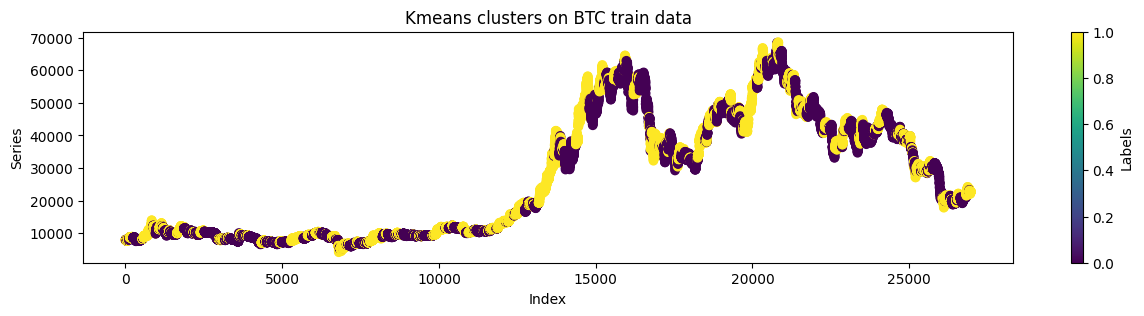

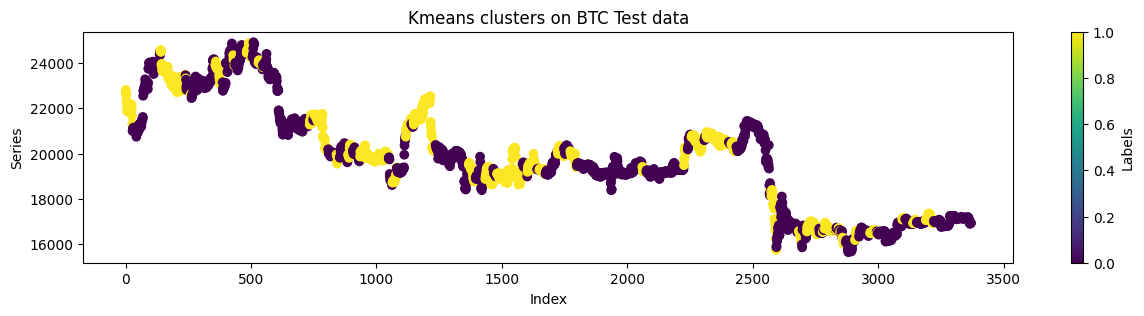

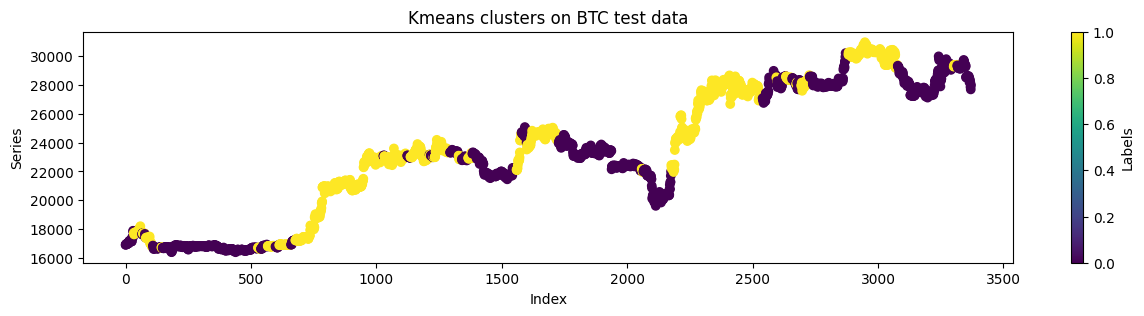

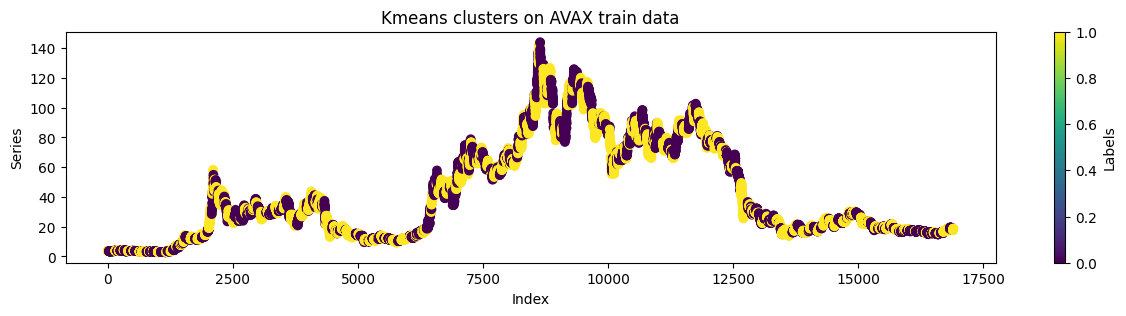

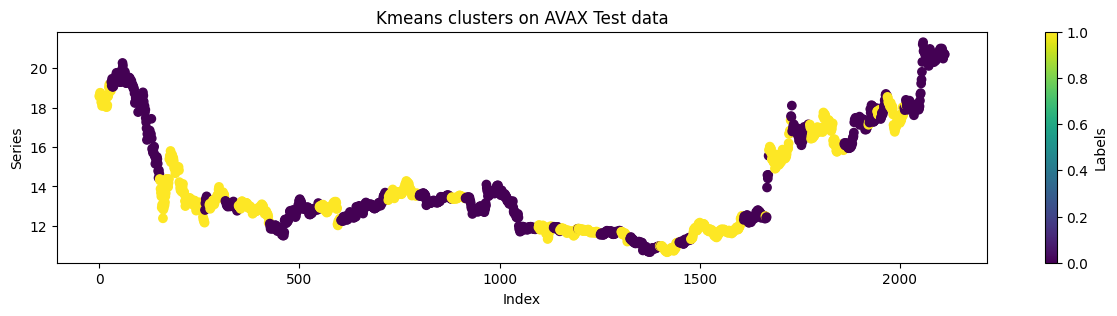

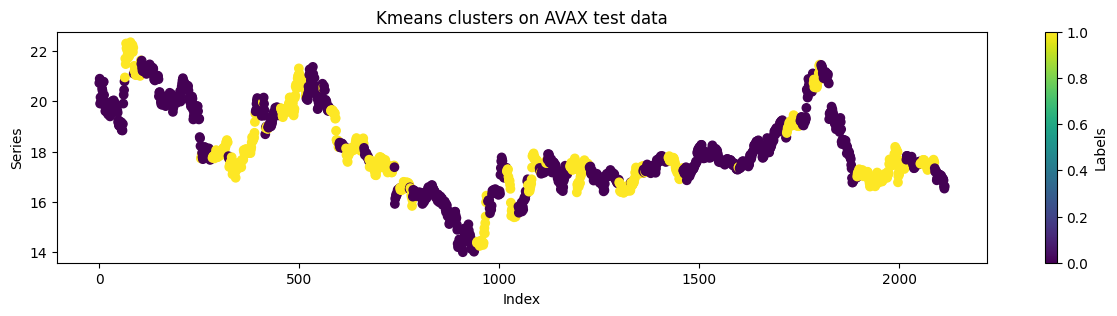

In [15]:
plot_2d(temp_df_btc_raw.loc[btc_train_idxs]['close'], btc_train_clusters_df, "Kmeans clusters on BTC train data")
plot_2d(temp_df_btc_raw.loc[btc_val_idxs][['close']].values, btc_val_clusters_df, "Kmeans clusters on BTC Test data")
plot_2d(temp_df_btc_raw.loc[btc_test_idxs][['close']].values, btc_test_clusters_df, "Kmeans clusters on BTC test data")

plot_2d(temp_df_avax_raw.loc[avax_train_idxs][['close']].values, avax_train_clusters_df, "Kmeans clusters on AVAX train data")
plot_2d(temp_df_avax_raw.loc[avax_val_idxs][['close']].values, avax_val_clusters_df, "Kmeans clusters on AVAX Test data")
plot_2d(temp_df_avax_raw.loc[avax_test_idxs][['close']].values, avax_test_clusters_df, "Kmeans clusters on AVAX test data")

### Few Shot Learning

In [61]:
# calculate forwared return 
temp_df_btc_raw['one_day_ret'] = temp_df_btc_raw['close'] - temp_df_btc_raw['close'].shift(-1)
temp_df_avax_raw['one_day_ret'] = ( temp_df_avax_raw['close'].shift(-1) - temp_df_avax_raw['close'] ) / temp_df_avax_raw['close']


In [80]:
# train_idx_cluster_1 = avax_train_clusters_df[ (avax_train_clusters_df == 1) ].index
# val_idx_cluster_1 = avax_val_clusters_df[ (avax_val_clusters_df == 1) ].index
# test_idx_cluster_1 = avax_test_clusters_df[ (avax_test_clusters_df == 1) ].index
# temp_df_avax_raw['one_day_ret'].loc[val_idx_cluster_1].cumsum().plot()

In [ ]:
#init regression model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
# from sklearn.svm import SVR

regression_model = LinearRegression().fit(repr_btc_train_df, temp_df_btc_raw.loc[btc_train_idxs]['one_day_ret'])
# regression_model = SVR().fit(repr_btc_train_df, temp_df_btc_raw.loc[btc_train_idxs]['one_day_ret'])
# regression_model = Ridge(alpha=1.0).fit(repr_btc_train_df, temp_df_btc_raw.loc[btc_train_idxs]['one_day_ret'])
regression_model.score(repr_btc_train_df, temp_df_btc_raw.loc[btc_train_idxs]['one_day_ret'])

0.011140743181884405

In [ ]:
temp = pd.DataFrame( regression_model.predict(repr_btc_train_df), columns=['pred'], index=btc_train_idxs )
temp['one_day_ret'] = temp_df_btc_raw.loc[btc_train_idxs]['one_day_ret'].values
temp = np.sign(temp)
(temp['pred'] == temp['one_day_ret']).value_counts() / len(temp)

In [ ]:
temp = pd.DataFrame( regression_model.predict(repr_btc_val_df), columns=['pred'], index=btc_val_idxs )
temp['one_day_ret'] = temp_df_btc_raw.loc[btc_val_idxs]['one_day_ret'].values
temp = np.sign(temp)
(temp['pred'] == temp['one_day_ret']).value_counts() / len(temp)

False    0.50441
True     0.49559
dtype: float64

In [ ]:
temp = pd.DataFrame( regression_model.predict(repr_btc_test_df), columns=['pred'], index=btc_test_idxs )
temp['one_day_ret'] = temp_df_btc_raw.loc[btc_test_idxs]['one_day_ret'].values
temp = np.sign(temp)
(temp['pred'] == temp['one_day_ret']).value_counts() / len(temp)

True     0.510744
False    0.489256
dtype: float64